# Effects of  attention on Covid analysis

In this notebook, we wish to show the pipeline we will use to explore the effects that increased attention on Covid in a country had on the percentage of people infected and dead as a consequence of Covid in this country. The pipeline in this notebook includes:
1. Computing the `covid attention score` for each country
2. Create a new dataset describing the county, its policies, and general situation during the first wave of the pandemic
3. Add Covid's outcome (number of infections and deaths) after the end of the first wave for each country in this dataset
4. Compute the propensity score for each country
5. Balancing the dataset via matching

The fundamental idea of this task is to explore the effects of the overall interest in Covid and its presence in social media topics (e.g., Twitter) in the period that preceded the official lockdowns (or any other similar measure, e.g., school closure or ban of the public events", for countries that did not impose the lockdowns) on the resulting percentage of people infected and died for each country.

It is important to note why we focus on the exact period before the lockdowns (or other significant measures): during this period Covid has spread mostly across countries (afterward lockdowns mitigated its spread), so we want to inspect how influential people and general public's attention on Covid help (or not?) country fight pandemic when, in essence, this was the only way to set people behavior, e.g., staying at home, avoiding social contacts, before this behavior was imposed by governments. 

For the purposes of the second project Milestone, we display how pipelines work in just two countries: Serbia and Italy. The goal of this notebook is just to show how to extract and prepare the data for our study in the final milestone where we will extend the analysis to various countries.

In [94]:
import pandas as pd
import numpy as np
from scipy import stats

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Twitter library
import tweepy

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Topic analysis libraries
import pyLDAvis 
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models as gensimvi

import gensim
from gensim import corpora
import pickle
import bz2
import json

import warnings
warnings.filterwarnings("ignore")

import spacy
%matplotlib inline

## 1. Covid attention score

In order to compute the `covid attention score` for each country, we can rely on two sources:
1. Twitter data of influential people - represents the presence of COVID in the media
2. Wikipedia pageviews - represent the people's general interest in Covid

We gather this data for each country for the period of 3 weeks before the official lockdown imposed by the government. Then for Twitter data, we utilize the LDA topic model to pick up the key topics talked about by influential people on Twitter. Thus, we can find the topic that is related to pandemics, covid, lockdown, and so on, and find the percentage of tokens related to it. This percentage is our score for the presence of COVID on social media. Next, we use the `aggregated_timeseries.json` dataset to get the average percentage of pageviews going to covid-related pages per day for pages in the appropriate language for the country we analyze.

Finally, we average these two results by Harmonic mean to obtain the Covid attention score. We use the Harmonic mean to evenly weight the influence of each of the percentage scores we use. For example, 1\% pageviews to covid-related pages represent a very significant interest to Covid compared to the number of topics available on Wikipedia. On the other hand, the number of topics we can explore by topic analysis is orders of magnitude smaller, so significant attention to Covid is characterized by a larger percentage. 

### Load data

In [2]:
# twitter data for influential people
influential_people_tweets = pd.read_csv('output/influential_people_tweets.csv', delimiter=',')
influential_people_tweets.head()

,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,1234249601517047814,RS,sr,Response(data=<User id=356450858 name=Александ...,Хвала @AIPAC на изузетној части да говорим на ...,thanks on an exceptional honor to speak at the...,2020-03-01 22:50:10+00:00,"[{'domain': {'id': '45', 'name': 'Brand Vertic..."
1,1234183480625553410,RS,sr,Response(data=<User id=205153283 name=Dragan D...,"Ovakvih snimaka, kao ni onih kada ih izbacuju ...",several recordings like no ones when they thro...,2020-03-01 18:27:26+00:00,[]
2,1234196504123969536,RS,sr,Response(data=<User id=834073582514888710 name...,"Da li stel primetili suptilnu, ali vrlo podmuk...",did stel noticed a subtle but very insidious s...,2020-03-01 19:19:11+00:00,[]
3,1234253894244536323,RS,sr,Response(data=<User id=181338564 name=Marija S...,Safe trip girls🎉 #Hurricane,safe trip girls #hurricane,2020-03-01 23:07:14+00:00,[]
4,1234252303810600961,RS,sr,Response(data=<User id=181338564 name=Marija S...,Jebote jel su ljudi zaboravili da se raduju ????,fuck did people forget that they are looking f...,2020-03-01 23:00:55+00:00,[]


In [3]:
# json data of aggregated time-series of wikipedia pageviews
json_file_path = "data/aggregated_timeseries.json"
with open(json_file_path, 'r') as j:
     aggregated_timeseries = json.loads(j.read())

Let's show countries that we analyze in this notebook.

In [4]:
influential_people_tweets['country_code'].value_counts()

IT    4691
CA    4004
JA    3713
FI    3559
FR    2549
DE    1301
SE    1281
NO     963
DK     930
KO     644
NL     611
RS     361
Name: country_code, dtype: int64

As we can see from the results above there are 12 diffrent countries from which we will look at the tweets from influencial people. They are:

1. IT - Italy
2. CA - Canada
3. JA - Japan
4. FI - Finland
5. FR - France
6. DE - Germany
7. SE - Sweden
8. NO - Norway
9. DK - Denmark
10. KO - Korea
11. NL - Netherlands
12. RS - Serbia

For calculating the presence of covid related tweets we use topics modeling and a function which creates LDA model explained in notebook related to RQ2.

In [5]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    # Initialize spaCy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# constructing pair of words
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

# constructing set of three words
def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [6]:
# function for creating LDA model
def createLDAModel(influential_people_tweets, country_code, number_topics):
    """
    Function which creates LDA model 
    
    Arguments:
        influential_people_tweets: dataset which contains tweets from influential people
        country_code: country for which we are creating model 
        number_topics: number of topics 
    """
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                            'tweet_text_en']

    data_words = []
    for row in tweets_from_country:
        data_words.append(str(row).split())

    #print("Words example\n", data_words[:1])

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    #print("\nTrigram example\n", trigram_mod[bigram_mod[data_words[0]]])

    data_words_bigrams = make_bigrams(data_words, bigram_mod)

    # Perform lemmatization keeping noun, adjective, verb, and adverb
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #, 'ADJ', 'VERB', 'ADV'

    #print("\nData lemmatization\n", data_lemmatized[:1])

    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Create a LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=number_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=5,
                                               passes=10,
                                               alpha='auto',
                                               eval_every=5, 
                                               per_word_topics=True)

    doc_lda = lda_model[corpus]

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    pyLDAvis.enable_notebook()
    visualization = gensimvi.prepare(lda_model, corpus, id2word)
    return visualization

For calculating the percentage of pageviews going to covid-related pages per day for pages, we use the following function.

In [7]:
def get_percetage_wikiviews(country_code, start, end):
    # We get the dates belonging to the 3-week period before the lockdown starts in Italy 
    dates = [date for date in pd.to_datetime(
        list(aggregated_timeseries[country_code + ".m"]["covid"]["sum"].keys()))  if date >= start]

    dates = [date for date in dates if date <= end]
    
    # Get the percentage of visits to covid-related pages for each day with respect to the total number of visits to Wikipedia pages 
    # for both mobile and desktop devices.
    covid_visits = pd.Series(
        [(aggregated_timeseries[country_code + ".m"]["covid"]["sum"][str(key)] + aggregated_timeseries[
            country_code]["covid"]["sum"][str(key)]) / (aggregated_timeseries[
            country_code + ".m"]["sum"][str(key)] + aggregated_timeseries["it"]["sum"][str(key)]) for key in dates])
    
    print(covid_visits.describe())
    return covid_visits.mean()

### Covid attention score Italy

In [8]:
visualization = createLDAModel(influential_people_tweets, 'IT', 4)
visualization


Perplexity:  -9.100461513491963


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.100379  0.092067       1        1  27.306358
1      0.004211 -0.043637       2        1  25.522652
0      0.019554 -0.104874       3        1  23.695982
3     -0.124144  0.056444       4        1  23.475008, topic_info=             Term        Freq       Total Category  logprob  loglift
27          today  243.000000  243.000000  Default  30.0000  30.0000
770       measure  243.000000  243.000000  Default  29.0000  29.0000
627     emergency  236.000000  236.000000  Default  28.0000  28.0000
380   coronavirus  187.000000  187.000000  Default  27.0000  27.0000
109         photo  157.000000  157.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3168     dialogue   28.874635  134.483877   Topic4  -4.9429  -0.0892
2236       sinner   26.719575  118.622567   Topic4  -5.0205  -0.0413
1989         snow   26.701730  118.687671   Topic4  -5.0211  -0.0425
856     lombardia   26.325167  117.097444   Topic4  -5.0353  -0.0432
86       prisoner   21.552533   90.393472   Topic4  -5.2354   0.0156

[185 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
281       2  0.991873         #
398       1  0.823230  accident
398       2  0.048425  accident
398       3  0.048425  accident
398       4  0.048425  accident
...     ...       ...       ...
82        4  0.945928      word
9         2  0.991820      work
352       1  0.969123    worker
394       4  0.984742     world
39        3  0.991700      year

[257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 27.3% of tokens, which means that we can estimate that around 27.3% of discussions are Covid-related.

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Italy.

In [9]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 19)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 10)
views_it = get_percetage_wikiviews("it", start, end)

count    21.000000
mean      0.002502
std       0.001567
min       0.000243
25%       0.001370
50%       0.002135
75%       0.003451
max       0.006197
dtype: float64


Let's find the Covid attention score based on the formula we described before.

In [10]:
attention = {"Italy": 2 * views_it * 0.273 / (views_it + 0.273)}
print("Covid attention score for Italy:", attention["Italy"])

Covid attention score for Italy: 0.004959528316860655


### Covid attention score Serbia

In [11]:
visualization = createLDAModel(influential_people_tweets, 'RS', 6)
visualization


Perplexity:  -8.897632919179932


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.118261 -0.093549       1        1  21.406186
1      0.147337 -0.024514       2        1  20.424843
4      0.031805  0.163963       3        1  15.312383
0     -0.102305  0.043756       4        1  15.201501
3     -0.034075  0.012967       5        1  13.950118
2      0.075499 -0.102622       6        1  13.704968, topic_info=            Term       Freq      Total Category  logprob  loglift
665  celebration  33.000000  33.000000  Default  30.0000  30.0000
3         people  13.000000  13.000000  Default  29.0000  29.0000
339      measure  17.000000  17.000000  Default  28.0000  28.0000
6          thank  10.000000  10.000000  Default  27.0000  27.0000
142          man  14.000000  14.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
662      patient   2.459826   5.297411   Topic6  -4.2370   1.2203
663          sns   2.459826   5.297411   Topic6  -4.2370   1.2203
637   motivation   1.681583   3.389462   Topic6  -4.6173   1.2865
638     optimism   1.681583   3.389462   Topic6  -4.6173   1.2865
639        track   1.681583   3.389462   Topic6  -4.6173   1.2865

[249 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
86        2  0.653758         #
627       3  0.885128    access
264       1  0.918698   account
568       4  0.511855    action
506       5  0.773920  activist
...     ...       ...       ...
347       6  0.932040    worker
76        2  0.823384     world
13        2  0.664796      year
619       3  0.333166    између
619       6  0.666331    између

[285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 1, 4, 3])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 21.4% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Serbia.

In [12]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 29)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 20)
views_sr = get_percetage_wikiviews("sr", start, end)

count    21.000000
mean      0.000103
std       0.000105
min       0.000005
25%       0.000010
50%       0.000027
75%       0.000212
max       0.000261
dtype: float64


In [13]:
attention["Serbia"] = 2 * views_sr * 0.214 / (views_sr + 0.214)
print("Covid attention score for Serbia:", attention["Serbia"])

Covid attention score for Serbia: 0.0002064621706590956


### Covid attention score Canada

In [14]:
visualization = createLDAModel(influential_people_tweets, 'CA', 3)
visualization


Perplexity:  -9.071950412053365


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.107327  0.001591       1        1  42.871192
2     -0.051710 -0.066345       2        1  31.694291
0     -0.055617  0.064754       3        1  25.434517, topic_info=               Term        Freq       Total Category  logprob  loglift
231          travel  159.000000  159.000000  Default  30.0000  30.0000
134          market  207.000000  207.000000  Default  29.0000  29.0000
4       coronavirus  177.000000  177.000000  Default  28.0000  28.0000
32           health  118.000000  118.000000  Default  27.0000  27.0000
68             case  100.000000  100.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
894           value   12.678245   52.782380   Topic3  -5.7548  -0.0572
14       quarantine   15.334068   80.327269   Topic3  -5.5646  -0.2870
2724  selfisolation   11.789096   49.863580   Topic3  -5.8275  -0.0731
1078       employee   10.775591   42.697975   Topic3  -5.9174  -0.0078
941      retirement   11.530956   60.110120   Topic3  -5.8497  -0.2821

[179 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
653       1  0.987226         #
1214      1  0.371242  activist
1214      2  0.346493  activist
1214      3  0.272244  activist
79        1  0.919476  analysis
...     ...       ...       ...
19        1  0.892073    worker
19        2  0.059472    worker
19        3  0.059472    worker
78        1  0.988765     world
43        1  0.995610      year

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 42.9% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Canada.

In [15]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 22)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 13)
views_ca = get_percetage_wikiviews("ca", start, end)

count    21.000000
mean      0.000140
std       0.000091
min       0.000024
25%       0.000093
50%       0.000110
75%       0.000162
max       0.000362
dtype: float64


In [16]:
attention["Canada"] = 2 * views_ca * 0.429 / (views_ca + 0.429)
print("Covid attention score for Canada:", attention["Canada"])

Covid attention score for Canada: 0.0002807447767778885


### Covid attention score Japan

In [17]:
visualization = createLDAModel(influential_people_tweets, 'JA', 6)
visualization


Perplexity:  -8.378739021581895


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.295544  0.001402       1        1  34.451139
3     -0.055027 -0.231140       2        1  15.819579
4     -0.051147  0.121605       3        1  15.272848
1     -0.059491  0.039218       4        1  14.570716
2     -0.068622  0.048739       5        1  13.633147
0     -0.061258  0.020176       6        1   6.252571, topic_info=               Term        Freq       Total Category  logprob  loglift
2            nhknew  861.000000  861.000000  Default  30.0000  30.0000
52           number  304.000000  304.000000  Default  29.0000  29.0000
135       infection  527.000000  527.000000  Default  28.0000  28.0000
81             time  261.000000  261.000000  Default  27.0000  27.0000
8                 #  433.000000  433.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
42         property    5.104035   53.786767   Topic6  -5.4489   0.4172
1153            bar    9.102361  137.506166   Topic6  -4.8704   0.0570
2675           soul    4.009059   36.962742   Topic6  -5.6904   0.5508
894   entertainment    3.993645   40.862493   Topic6  -5.6943   0.4467
608           music    3.767306   35.825121   Topic6  -5.7526   0.5199

[273 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8         1  0.997371          #
501       3  0.985558   activity
291       2  0.962820   addition
161       4  0.992144        app
656       4  0.954153        art
...     ...       ...        ...
1246      5  0.160642   yamagata
1246      6  0.128513   yamagata
36        2  0.992902       year
50        6  0.467062        yen
397       2  0.953249  yesterday

[468 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 2, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 34.5% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Japan.

In [18]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 3, 10)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 30)
views_ja = get_percetage_wikiviews("ja", start, end)

count    21.000000
mean      0.002927
std       0.000477
min       0.002157
25%       0.002517
50%       0.002998
75%       0.003195
max       0.004060
dtype: float64


In [19]:
attention["Japan"] = 2 * views_ja * 0.345 / (views_ja + 0.345)
print("Covid attention score for Japan:", attention["Japan"])

Covid attention score for Japan: 0.005805692760968661


### Covid attention score Finland

In [20]:


visualization = createLDAModel(influential_people_tweets, 'FI', 4)
visualization


Perplexity:  -9.249128567169828


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.124788  0.069546       1        1  28.658600
1     -0.004312 -0.134521       2        1  26.811373
2      0.117964  0.069035       3        1  25.033492
0      0.011136 -0.004060       4        1  19.496535, topic_info=                Term        Freq       Total Category  logprob  loglift
955   reader_opinion  230.000000  230.000000  Default  30.0000  30.0000
331        infection  173.000000  173.000000  Default  29.0000  29.0000
200           school  155.000000  155.000000  Default  28.0000  28.0000
161             home  118.000000  118.000000  Default  27.0000  27.0000
93              time  148.000000  148.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
793        education   12.180720   79.467655   Topic4  -5.5561  -0.2406
1455       recycling    7.508892   31.238754   Topic4  -6.0399   0.2094
1661           novel    7.744271   39.170663   Topic4  -6.0090   0.0140
1683  recommendation    7.602296   39.114275   Topic4  -6.0275  -0.0031
1946         package    7.544105   38.800996   Topic4  -6.0352  -0.0027

[175 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1273      1  0.928451    action
40        1  0.925937  activity
40        2  0.040258  activity
40        3  0.040258  activity
40        4  0.040258  activity
...     ...       ...       ...
106       4  0.996028      week
227       3  0.966383     woman
278       1  0.994025      work
184       3  0.997403     world
125       2  0.992890      year

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 3 is related to the covid and it contains 25% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Finland.

In [21]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 24)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 15)
views_fi = get_percetage_wikiviews("fi", start, end)

count    21.000000
mean      0.000981
std       0.000893
min       0.000366
25%       0.000460
50%       0.000602
75%       0.000821
max       0.003443
dtype: float64


In [22]:
attention["Finland"] = 2 * views_fi * 0.25 / (views_fi + 0.25)
print("Covid attention score for Finland:", attention["Finland"])

Covid attention score for Finland: 0.001953529487293006


### Covid attention score France

In [23]:
visualization = createLDAModel(influential_people_tweets, 'FR', 5)
visualization


Perplexity:  -9.696878085199007


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.183913  0.031263       1        1  29.219948
2      0.084250  0.146928       2        1  23.596230
0      0.044949 -0.098199       3        1  18.288953
4      0.024709 -0.034949       4        1  14.543532
1      0.030005 -0.045042       5        1  14.351337, topic_info=              Term        Freq       Total Category  logprob  loglift
53               #  315.000000  315.000000  Default  30.0000  30.0000
13     coronavirus  262.000000  262.000000  Default  29.0000  29.0000
468            day  104.000000  104.000000  Default  28.0000  28.0000
15        epidemic  145.000000  145.000000  Default  27.0000  27.0000
76              pm  103.000000  103.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
3170    accelerate    6.433789   37.255480   Topic5  -5.6719   0.1851
1628  announcement    6.868524   43.853456   Topic5  -5.6065   0.0874
520       pandemic    8.008496   75.258671   Topic5  -5.4529  -0.2991
11         morning    6.311050   37.033750   Topic5  -5.6912   0.1718
2255          noon    6.298260   37.049579   Topic5  -5.6932   0.1693

[241 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
53        2  0.997290           #
1420      1  0.241421  abstention
1420      2  0.206932  abstention
1420      3  0.189688  abstention
1420      4  0.189688  abstention
...     ...       ...         ...
873       4  0.045445        word
873       5  0.045445        word
144       1  0.986189        work
245       2  0.991229       world
52        2  0.975239        year

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 29.2% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for France.

In [24]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 25)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 16)
views_fr = get_percetage_wikiviews("fr", start, end)

count    21.000000
mean      0.001186
std       0.000855
min       0.000510
25%       0.000659
50%       0.000739
75%       0.001122
max       0.002984
dtype: float64


In [25]:
attention["France"] = 2 * views_fr * 0.292 / (views_fr + 0.292)
print("Covid attention score for France:", attention["France"])

Covid attention score for France: 0.002363236779783313


### Covid attention score Germany

In [26]:
visualization = createLDAModel(influential_people_tweets, 'DE', 4)
visualization


Perplexity:  -8.497098291379663


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.150112  0.007267       1        1  41.829144
3     -0.062307  0.076976       2        1  24.317683
0     -0.042905 -0.038737       3        1  17.287047
2     -0.044900 -0.045506       4        1  16.566126, topic_info=             Term        Freq       Total Category  logprob  loglift
0               #  200.000000  200.000000  Default  30.0000  30.0000
5          crisis  121.000000  121.000000  Default  29.0000  29.0000
65         corona  180.000000  180.000000  Default  28.0000  28.0000
9      coronaviru  126.000000  126.000000  Default  27.0000  27.0000
61    coronavirus  119.000000  119.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1034    thank_you    2.935910   17.461352   Topic4  -5.7473   0.0148
1649        mouth    2.654569   13.856288   Topic4  -5.8480   0.1454
1101   wirvsvirus    4.128564   48.681625   Topic4  -5.4064  -0.6696
754           tax    2.791587   16.251876   Topic4  -5.7977   0.0362
1131       parent    2.905930   19.706271   Topic4  -5.7575  -0.1164

[272 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.995833        #
922       1  0.672442   action
922       2  0.144095   action
922       3  0.096063   action
922       4  0.096063   action
...     ...       ...      ...
158       2  0.946441     year
1620      1  0.270396  youtube
1620      2  0.270396  youtube
1620      3  0.270396  youtube
1620      4  0.270396  youtube

[499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 41.8% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Germany.

In [27]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 3, 1)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 21)
views_de = get_percetage_wikiviews("de", start, end)

count    21.000000
mean      0.008865
std       0.007936
min       0.001223
25%       0.001948
50%       0.002963
75%       0.015895
max       0.023933
dtype: float64


In [28]:
attention["Germany"] = 2 * views_de * 0.418 / (views_de + 0.418)
print("Covid attention score for Germany:", attention["Germany"])

Covid attention score for Germany: 0.017361740045669257


### Covid attention score Sweden

In [29]:
visualization = createLDAModel(influential_people_tweets, 'SE', 5)
visualization


Perplexity:  -9.46049979205268


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.018098  0.010327       1        1  24.340500
1      0.073276 -0.099723       2        1  21.205418
3     -0.135718 -0.025959       3        1  21.174473
0      0.034566  0.099621       4        1  18.643562
4      0.009778  0.015733       5        1  14.636047, topic_info=            Term       Freq      Total Category  logprob  loglift
30         thing  92.000000  92.000000  Default  30.0000  30.0000
307       corona  88.000000  88.000000  Default  29.0000  29.0000
231       leader  63.000000  63.000000  Default  28.0000  28.0000
434      meeting  63.000000  63.000000  Default  27.0000  27.0000
656    authority  52.000000  52.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
172          law   3.634101  35.100116   Topic5  -5.4111  -0.3462
113   profession   2.903054  17.244343   Topic5  -5.6357   0.1400
1599     housing   3.012038  22.054104   Topic5  -5.5989  -0.0692
317      reading   2.898585  17.207505   Topic5  -5.6373   0.1406
1493     caution   2.915055  19.334129   Topic5  -5.6316   0.0297

[276 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
504       1  0.831981  accident
505       5  0.706013       act
99        4  0.991023    action
838       1  0.309426    agency
838       2  0.154713    agency
...     ...       ...       ...
1722      1  0.311478    yetlag
1722      2  0.155739    yetlag
1722      3  0.155739    yetlag
1722      4  0.155739    yetlag
1722      5  0.155739    yetlag

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 4 is related to the covid and it contains 18.6% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Sweden.

In [30]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 19)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 10)
views_sv = get_percetage_wikiviews("sv", start, end)

count    21.000000
mean      0.000005
std       0.000005
min       0.000002
25%       0.000003
50%       0.000004
75%       0.000005
max       0.000023
dtype: float64


In [31]:
attention["Sweden"] = 2 * views_sv * 0.186 / (views_sv + 0.186)
print("Covid attention score for Sweden:", attention["Sweden"])

Covid attention score for Sweden: 1.0648297019484119e-05


### Covid attention score Norway

In [32]:
visualization = createLDAModel(influential_people_tweets, 'NO', 4)
visualization


Perplexity:  -8.568437714798247


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.140396  0.065795       1        1  31.412597
3      0.120665  0.089278       2        1  27.879013
1      0.009399 -0.071698       3        1  20.641769
0      0.010333 -0.083374       4        1  20.066621, topic_info=            Term        Freq       Total Category  logprob  loglift
220         time  149.000000  149.000000  Default  30.0000  30.0000
234        virus  130.000000  130.000000  Default  29.0000  29.0000
168          amp   88.000000   88.000000  Default  28.0000  28.0000
80       country   74.000000   74.000000  Default  27.0000  27.0000
54          life   57.000000   57.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
42       company    3.476308   15.534965   Topic4  -5.6062   0.1090
1385  fraternity    3.930435   18.678876   Topic4  -5.4834   0.0475
468      service    4.135347   24.414443   Topic4  -5.4326  -0.1695
908     struggle    3.273730   15.370573   Topic4  -5.6662   0.0596
461         word    3.322798   27.016098   Topic4  -5.6514  -0.4895

[205 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         3  0.939202          #
72        4  0.842296     action
92        1  0.258991  agreement
92        2  0.258991  agreement
92        4  0.517982  agreement
...     ...       ...        ...
71        1  0.918313       year
1170      1  0.331145  yesterday
1170      2  0.248359  yesterday
1170      3  0.248359  yesterday
1170      4  0.248359  yesterday

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 3 is related to the covid and it contains 20.6% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Norway.

In [33]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 3, 3)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 23)
views_no = get_percetage_wikiviews("no", start, end)

count    21.000000
mean      0.000413
std       0.000188
min       0.000176
25%       0.000273
50%       0.000399
75%       0.000471
max       0.000848
dtype: float64


In [34]:
attention["Norway"] = 2 * views_no * 0.206 / (views_no + 0.206)
print("Covid attention score for Norway:", attention["Norway"])

Covid attention score for Norway: 0.0008244494884565935


### Covid attention score Denmark

In [35]:
visualization = createLDAModel(influential_people_tweets, 'DK', 6)
visualization


Perplexity:  -9.6226207625076


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.077326  0.128367       1        1  24.953064
0      0.181705  0.031579       2        1  18.774568
4     -0.031694 -0.038344       3        1  18.417095
1     -0.028725 -0.043797       4        1  16.440878
5     -0.022697 -0.042032       5        1  10.903413
2     -0.021262 -0.035774       6        1  10.510982, topic_info=           Term       Freq      Total Category  logprob  loglift
92       police  54.000000  54.000000  Default  30.0000  30.0000
157        time  34.000000  34.000000  Default  29.0000  29.0000
70       people  42.000000  42.000000  Default  28.0000  28.0000
78      denmark  47.000000  47.000000  Default  27.0000  27.0000
80   right_here  34.000000  34.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
230        form   1.353793  12.093256   Topic6  -5.5521   0.0630
105      mirage   1.363240  12.419126   Topic6  -5.5451   0.0434
218           #   1.986961  39.709985   Topic6  -5.1684  -0.7422
57        match   1.436719  17.411444   Topic6  -5.4926  -0.2420
61         look   1.352585  13.732240   Topic6  -5.5530  -0.0650

[357 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
218       1  0.428104               #
218       2  0.151095               #
218       3  0.176278               #
218       4  0.125913               #
218       5  0.050365               #
...     ...       ...             ...
1246      5  0.181531  worthy_purpose
1246      6  0.090766  worthy_purpose
140       4  0.922593            year
265       1  0.321544       yesterday
265       3  0.321544       yesterday

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 6, 3])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 25% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Denmark.

In [36]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 26)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 17)
views_da = get_percetage_wikiviews("da", start, end)

count    21.000000
mean      0.000332
std       0.000197
min       0.000118
25%       0.000170
50%       0.000287
75%       0.000501
max       0.000675
dtype: float64


In [37]:
attention["Denmark"] = 2 * views_da * 0.25 / (views_da + 0.25)
print("Covid attention score for Denmark:", attention["Denmark"])

Covid attention score for Denmark: 0.000663740986036565


### Covid attention score Korea

In [38]:
visualization = createLDAModel(influential_people_tweets, 'KO', 8)
visualization


Perplexity:  -8.295024299071205


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.310462 -0.017199       1        1  25.317318
6     -0.012642 -0.166546       2        1  16.903941
4     -0.005402  0.253303       3        1  13.941289
5      0.045549 -0.006905       4        1  10.152241
7      0.085475 -0.035774       5        1   8.915987
2      0.104150 -0.012148       6        1   8.736624
3      0.033344  0.020846       7        1   8.122782
1      0.059986 -0.035579       8        1   7.909818, topic_info=           Term       Freq      Total Category  logprob  loglift
68      bitcoin  96.000000  96.000000  Default  30.0000  30.0000
46        level  65.000000  65.000000  Default  29.0000  29.0000
313       video  37.000000  37.000000  Default  28.0000  28.0000
48      support  43.000000  43.000000  Default  27.0000  27.0000
325        asot  20.000000  20.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
766     liveset   0.983986   2.286801   Topic8  -5.3210   1.6938
767         mix   0.983986   2.286801   Topic8  -5.3210   1.6938
193  commitment   0.925577   2.253006   Topic8  -5.3822   1.6475
814        bias   1.182878   5.433419   Topic8  -5.1369   1.0124
220      medium   1.149129   5.488294   Topic8  -5.1658   0.9735

[309 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
16        4  0.945977           #
751       1  0.862142     account
751       2  0.107768     account
535       6  0.483439    addition
812       8  0.791423  aftermovie
...     ...       ...         ...
677       1  0.577465     youtube
677       2  0.096244     youtube
677       3  0.096244     youtube
677       4  0.288732     youtube
94        7  0.932519        zone

[335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 6, 8, 3, 4, 2])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 3 is related to the covid and it contains 13.9% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Korea.

In [39]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 4)
# end of the observation period: mobility drop begins
end = datetime(2020, 2, 24)
views_ko = get_percetage_wikiviews("ko", start, end)

count    21.000000
mean      0.000234
std       0.000269
min       0.000018
25%       0.000025
50%       0.000166
75%       0.000260
max       0.000898
dtype: float64


In [40]:
attention["Republic of Korea"] = 2 * views_ko * 0.139 / (views_ko + 0.139)
print("Covid attention score for Korea:", attention["Republic of Korea"])

Covid attention score for Korea: 0.0004677106397146853


### Covid attention score Netherlands

In [41]:
visualization = createLDAModel(influential_people_tweets, 'NL', 8)
visualization


Perplexity:  -8.605677288521736


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.298479 -0.055054       1        1  22.148895
4      0.001791  0.235048       2        1  17.574331
3      0.098647 -0.164240       3        1  13.634184
0      0.034382 -0.004915       4        1  10.553755
6      0.037460 -0.000866       5        1   9.429816
1      0.043761 -0.002548       6        1   9.329155
2      0.039059  0.003844       7        1   8.948561
5      0.043378 -0.011270       8        1   8.381303, topic_info=         Term       Freq      Total Category  logprob  loglift
35    bitcoin  62.000000  62.000000  Default  30.0000  30.0000
56     market  73.000000  73.000000  Default  29.0000  29.0000
66   movement  42.000000  42.000000  Default  28.0000  28.0000
33        amp  58.000000  58.000000  Default  27.0000  27.0000
1     support  40.000000  40.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
778       npo   0.622164   4.478433   Topic8  -5.8345   0.5053
95     candle   0.943102   9.376868   Topic8  -5.4185   0.1823
92      start   1.809847  34.221244   Topic8  -4.7667  -0.4604
774     cheer   0.989237  11.177859   Topic8  -5.3708   0.0544
718    speech   0.973815  18.508598   Topic8  -5.3865  -0.4656

[352 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
133       6  0.641465        #
257       1  0.180409   action
257       2  0.180409   action
257       5  0.180409   action
257       6  0.360818   action
...     ...       ...      ...
126       6  0.939763  youtube
114       7  0.908782     zone
628       1  0.177573        ⁣
628       2  0.177573        ⁣
628       4  0.355146        ⁣

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 1, 7, 2, 3, 6])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 3 is related to the covid and it contains 13.6% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Netherlands.

In [42]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 24)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 15)
views_nl = get_percetage_wikiviews("nl", start, end)

count    21.000000
mean      0.001330
std       0.000811
min       0.000434
25%       0.000878
50%       0.001102
75%       0.001420
max       0.003002
dtype: float64


In [43]:
attention["Netherlands"] = 2 * views_nl * 0.136 / (views_nl + 0.136)
print("Covid attention score for Netherlands:", attention["Netherlands"])

Covid attention score for Netherlands: 0.0026342300840668607


### Review of the attention scores

In [44]:
attention

{'Italy': 0.004959528316860655,
 'Serbia': 0.0002064621706590956,
 'Canada': 0.0002807447767778885,
 'Japan': 0.005805692760968661,
 'Finland': 0.001953529487293006,
 'France': 0.002363236779783313,
 'Germany': 0.017361740045669257,
 'Sweden': 1.0648297019484119e-05,
 'Norway': 0.0008244494884565935,
 'Denmark': 0.000663740986036565,
 'Republic of Korea': 0.0004677106397146853,
 'Netherlands': 0.0026342300840668607}

We multiply the attention score by 1000, so we have a number that is nicer to both analyze and compare.

In [45]:
for country in attention:
    attention[country] *= 1000
attention

{'Italy': 4.959528316860656,
 'Serbia': 0.2064621706590956,
 'Canada': 0.2807447767778885,
 'Japan': 5.805692760968661,
 'Finland': 1.9535294872930062,
 'France': 2.3632367797833127,
 'Germany': 17.361740045669258,
 'Sweden': 0.010648297019484118,
 'Norway': 0.8244494884565935,
 'Denmark': 0.6637409860365651,
 'Republic of Korea': 0.4677106397146853,
 'Netherlands': 2.6342300840668607}

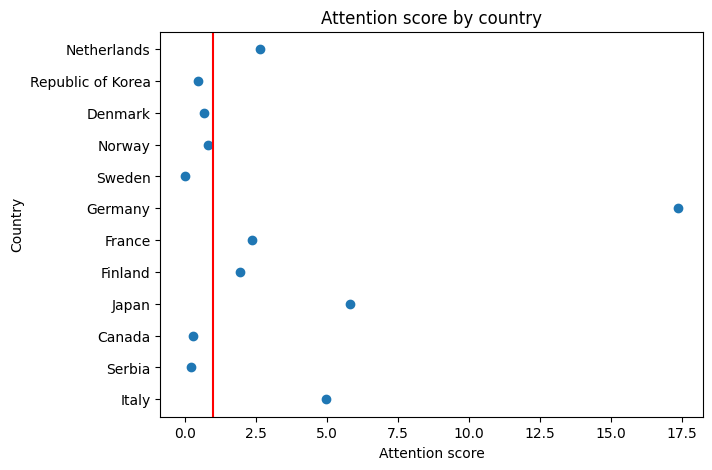

In [46]:
figure = plt.figure(figsize=(7, 5))
plt.scatter(list(attention.values()), list(attention.keys()))
plt.axvline(x=1, color='r')
plt.xlabel("Attention score")
plt.ylabel("Country")
plt.title("Attention score by country")
plt.show()

From the graph above, we can clearly divide the countries into two groups based on the attention score. Countries with the score less than 1 (*low score*) and more than 1 (*high score*). 

In [47]:
# We set that country with low attention score is labled with 0, otherwise with 1
for country in attention:
    if attention[country] < 1:
        attention[country] = 0
    else:
        attention[country] = 1
        
attention

{'Italy': 1,
 'Serbia': 0,
 'Canada': 0,
 'Japan': 1,
 'Finland': 1,
 'France': 1,
 'Germany': 1,
 'Sweden': 0,
 'Norway': 0,
 'Denmark': 0,
 'Republic of Korea': 0,
 'Netherlands': 1}

**Note** use k-means, chi-square, or something else to divide the results into two groups: high and low attention score.

## 2. Countries dataset

First, let's get the list of countries that we are interested in.

In [48]:
countries_list = list(attention.keys())
countries_list

['Italy',
 'Serbia',
 'Canada',
 'Japan',
 'Finland',
 'France',
 'Germany',
 'Sweden',
 'Norway',
 'Denmark',
 'Republic of Korea',
 'Netherlands']

For the second part, we wish to create a dataset that describes each country through a series of different attributes and also describes the situation in the country during the first Covid wave, e.g., the mobility of people, whether there was the official government imposed lockdown or not, etc.

In [49]:
# load apple mobility data
applemobilitytrends = pd.read_csv("data/applemobilitytrends-2020-04-20.csv.gz")
applemobilitytrends.sample(5) 

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
337,city,Rotterdam,walking,100,104.28,103.19,117.74,136.09,141.44,100.85,...,73.09,50.74,50.84,62.98,68.87,75.18,76.22,61.16,64.09,65.59
312,city,Oslo,driving,100,99.79,105.32,110.01,124.10,118.70,102.34,...,50.93,57.39,63.79,70.89,77.36,76.11,79.78,76.15,75.59,82.75
231,city,Frankfurt,walking,100,105.87,111.85,112.71,122.96,139.95,85.42,...,61.49,53.63,39.82,51.30,57.73,64.20,65.43,59.60,63.08,63.24
127,country/region,Sweden,transit,100,98.91,100.67,102.31,102.76,110.37,111.80,...,48.85,53.02,58.53,60.46,60.02,58.48,59.88,62.00,63.09,61.40
307,city,New York City,transit,100,92.66,95.29,96.42,107.50,101.22,93.41,...,12.52,11.25,12.75,14.13,13.42,13.34,13.46,12.10,12.61,14.58


In [50]:
# Get average mobility data by Apple for each country during observational period (3 weeks until the start of the lockdown). However, we 
# don't wish to look at the mobility data after the lockdown start because when the lockdown starts our observational 
# period begins (Rosenbaum). Thus, for each country, we compute the average mobility within its own observational period. 

# First, get the average mobility for each countries we look at for the each day available
mobility = applemobilitytrends.groupby("region").mean()
mobility = mobility[mobility.index.isin(countries_list)]
mobility

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
region,,,,,,,,,,,,,,,,,,,,,
Canada,100.0,103.076667,101.466667,104.940000,118.396667,104.900000,83.583333,102.063333,104.076667,106.910000,...,37.666667,30.240000,34.860000,40.586667,41.433333,42.633333,45.443333,43.116667,35.550000,45.783333
Denmark,100.0,100.356667,102.603333,103.900000,117.776667,113.536667,100.660000,100.506667,102.416667,105.130000,...,56.630000,58.463333,56.496667,59.576667,62.776667,64.630000,68.786667,67.396667,68.646667,70.400000
Finland,100.0,99.303333,101.980000,103.643333,111.566667,111.443333,100.380000,100.483333,101.370000,101.226667,...,60.146667,42.640000,60.830000,57.343333,58.726667,58.126667,66.460000,67.690000,69.680000,70.053333
France,100.0,102.620000,105.213333,110.740000,112.340000,120.483333,88.586667,92.796667,94.000000,96.946667,...,16.196667,13.653333,15.973333,20.413333,20.796667,21.030000,20.886667,17.663333,16.840000,21.520000
Germany,100.0,102.733333,104.136667,106.913333,117.610000,121.310000,99.026667,99.740000,102.170000,101.236667,...,51.620000,50.636667,48.856667,52.626667,56.490000,59.846667,59.220000,56.686667,62.133333,60.163333
Italy,100.0,101.850000,103.556667,104.340000,114.916667,127.720000,109.463333,101.306667,101.746667,103.970000,...,17.283333,10.933333,12.476667,16.160000,17.353333,17.726667,18.243333,17.410000,15.383333,16.376667
Japan,100.0,97.780000,100.770000,106.283333,129.190000,137.006667,105.093333,101.376667,101.930000,99.383333,...,60.813333,57.453333,66.500000,72.043333,70.623333,66.113333,56.176667,67.710000,58.540000,64.116667
Netherlands,100.0,101.686667,103.436667,107.410000,116.410000,119.850000,100.960000,101.393333,104.046667,104.446667,...,45.786667,35.113333,37.360000,41.290000,46.880000,48.436667,49.203333,44.096667,45.140000,46.486667
Norway,100.0,101.143333,103.870000,107.973333,121.870000,127.416667,106.243333,101.843333,103.470000,107.436667,...,44.333333,53.190000,57.790000,59.133333,66.000000,64.430000,68.956667,68.880000,71.123333,74.136667


In [51]:
# observation period for each country
periods = {'Italy': (datetime(2020, 2, 19), datetime(2020, 3, 10)),
 'Serbia': (datetime(2020, 2, 29), datetime(2020, 3, 20)),
 'Canada': (datetime(2020, 2, 22), datetime(2020, 3, 13)),
 'Japan': (datetime(2020, 3, 10), datetime(2020, 3, 30)),
 'Finland': (datetime(2020, 2, 24), datetime(2020, 3, 15)),
 'France': (datetime(2020, 2, 25), datetime(2020, 3, 16)),
 'Germany': (datetime(2020, 3, 1), datetime(2020, 3, 21)),
 'Sweden': (datetime(2020, 2, 19), datetime(2020, 3, 10)),
 'Norway': (datetime(2020, 3, 3), datetime(2020, 3, 23)),
 'Denmark': (datetime(2020, 2, 26), datetime(2020, 3, 17)),
 'Republic of Korea': (datetime(2020, 2, 4), datetime(2020, 2, 24)),
 'Netherlands': (datetime(2020, 2, 24), datetime(2020, 3, 15))}

# get average mobility for each country
average_mobility = {}
for country in countries_list:
    average_mobility[country] = mobility.loc[
        country, periods[country][0].strftime("%Y-%m-%d"): periods[country][1].strftime("%Y-%m-%d")].mean()
    
average_mobility = pd.DataFrame.from_dict(average_mobility, orient='index', columns=['mobility'])
average_mobility

,mobility
Italy,87.094286
Serbia,77.719286
Canada,107.043810
Japan,121.673333
Finland,100.205714
France,90.543810
Germany,87.055556
Sweden,111.287778
Norway,72.583333
Denmark,92.342063


In [52]:
# We load the countries dataset containing the various information about each country
countries = pd.read_csv("data/countries.csv", thousands=',')
countries["Country"] = countries["Country"].apply(lambda x : x.strip())

countries = countries[countries["Country"].isin(countries_list)].dropna(axis=1, how='any')
countries.drop("Region", axis=1, inplace=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,Crops,Other,Agriculture,Industry,Service
36,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,2.0,9502.0,22.0,294.0,684.0
54,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,19.0,4579.0,18.0,246.0,735.0
68,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,3.0,9278.0,28.0,295.0,676.0
69,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,207.0,644.0,22.0,214.0,764.0
76,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,59.0,6556.0,9.0,296.0,695.0
101,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,953.0,6268.0,21.0,291.0,688.0
103,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,96.0,8685.0,17.0,258.0,725.0
110,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,195.0,8087.0,33.0,403.0,563.0
146,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,97.0,7232.0,21.0,244.0,736.0
154,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,0.0,9713.0,21.0,415.0,564.0


In [53]:
# merging the mobility dataset with countries
countries = countries.merge(average_mobility, left_on="Country", right_index=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,Crops,Other,Agriculture,Industry,Service,mobility
36,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,2.0,9502.0,22.0,294.0,684.0,107.043810
54,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,19.0,4579.0,18.0,246.0,735.0,92.342063
68,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,3.0,9278.0,28.0,295.0,676.0,100.205714
69,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,207.0,644.0,22.0,214.0,764.0,90.543810
76,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,59.0,6556.0,9.0,296.0,695.0,87.055556
101,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,953.0,6268.0,21.0,291.0,688.0,87.094286
103,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,96.0,8685.0,17.0,258.0,725.0,121.673333
110,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,195.0,8087.0,33.0,403.0,563.0,76.992381
146,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,97.0,7232.0,21.0,244.0,736.0,101.570000
154,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,0.0,9713.0,21.0,415.0,564.0,72.583333


In [54]:
# load the mobility data from Google for Serbia and Italy
global_mobility = pd.read_csv("data/Global_Mobility_Report.csv")
# get the average mobility change for each countr-y during the pre-lockdown period
global_mobility = global_mobility[pd.to_datetime(global_mobility["date"]) <= datetime(2020, 2, 24)].groupby("country_region").mean()

global_mobility = global_mobility[global_mobility.index.isin(countries_list + ["South Korea"])].dropna(axis=1, how='any')
global_mobility.rename(index={"South Korea": "Republic of Korea"}, inplace=True)
global_mobility

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
country_region,,,,,,
Canada,3.596143,1.553039,21.401699,1.832134,-4.261084,0.928517
Denmark,-1.814324,-0.933766,-13.674877,-3.667575,-2.589502,1.031079
Finland,5.597663,2.895447,8.235632,1.854503,-6.211949,1.229979
France,3.416364,2.108974,27.965423,13.194238,-8.876364,1.442818
Germany,1.876471,1.200000,10.600000,1.041176,-4.352941,0.811765
Italy,0.325197,2.596063,20.746257,4.130366,-0.761417,-0.110410
Japan,1.283333,1.975000,5.514583,-0.756250,-4.877083,2.014583
Netherlands,1.723672,-0.376372,-4.325750,-4.100274,-7.999646,1.117909
Norway,0.856061,0.277311,4.120930,-0.826325,-10.969283,0.887805


In [55]:
# And we merge it with our country dataset
countries = countries.merge(global_mobility, left_on="Country", right_index=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,Agriculture,Industry,Service,mobility,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
36,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,...,22.0,294.0,684.0,107.043810,3.596143,1.553039,21.401699,1.832134,-4.261084,0.928517
54,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,...,18.0,246.0,735.0,92.342063,-1.814324,-0.933766,-13.674877,-3.667575,-2.589502,1.031079
68,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,...,28.0,295.0,676.0,100.205714,5.597663,2.895447,8.235632,1.854503,-6.211949,1.229979
69,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,...,22.0,214.0,764.0,90.543810,3.416364,2.108974,27.965423,13.194238,-8.876364,1.442818
76,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,...,9.0,296.0,695.0,87.055556,1.876471,1.200000,10.600000,1.041176,-4.352941,0.811765
101,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,...,21.0,291.0,688.0,87.094286,0.325197,2.596063,20.746257,4.130366,-0.761417,-0.110410
103,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,...,17.0,258.0,725.0,121.673333,1.283333,1.975000,5.514583,-0.756250,-4.877083,2.014583
110,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,...,33.0,403.0,563.0,76.992381,-12.850000,-3.050000,-6.250000,-10.750000,-1.250000,4.650000
146,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,...,21.0,244.0,736.0,101.570000,1.723672,-0.376372,-4.325750,-4.100274,-7.999646,1.117909
154,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,...,21.0,415.0,564.0,72.583333,0.856061,0.277311,4.120930,-0.826325,-10.969283,0.887805


In [56]:
# Finally, we load the interventions dataset
interventions = pd.read_csv("data/interventions.csv")
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaN


In [57]:
# get the flag feature describing whether the country had an offical lockdown: 0 - no, 1 - yes
interventions["had_lockdown"] = interventions["Lockdown"].apply(lambda x : 1 if isinstance(x, str) else 0)
interventions = interventions[["lang", "had_lockdown"]].iloc[:-1]
interventions

,lang,had_lockdown
0,fr,1
1,da,1
2,de,1
3,it,1
4,nl,0
5,no,1
6,sr,1
7,sv,0
8,ko,0
9,ca,1


In [58]:
# create a corresponding Country names column
interventions['Country'] = ["France", "Denmark", "Germany", "Italy", "Netherlands", "Norway", "Serbia", "Sweden", "Republic of Korea", 
                           "Canada", "Finland", "Japan"]
interventions = interventions[["Country", "had_lockdown"]]
interventions

,Country,had_lockdown
0,France,1
1,Denmark,1
2,Germany,1
3,Italy,1
4,Netherlands,0
5,Norway,1
6,Serbia,1
7,Sweden,0
8,Republic of Korea,0
9,Canada,1


In [59]:
# add this flag feature to our countries dataset
countries = countries.merge(interventions, on="Country")
countries.set_index("Country", inplace=True)
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,Industry,Service,mobility,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,had_lockdown
Country,,,,,,,,,,,,,,,,,,,,,
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,294.0,684.0,107.043810,3.596143,1.553039,21.401699,1.832134,-4.261084,0.928517,1
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,246.0,735.0,92.342063,-1.814324,-0.933766,-13.674877,-3.667575,-2.589502,1.031079,1
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,295.0,676.0,100.205714,5.597663,2.895447,8.235632,1.854503,-6.211949,1.229979,0
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,214.0,764.0,90.543810,3.416364,2.108974,27.965423,13.194238,-8.876364,1.442818,1
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,296.0,695.0,87.055556,1.876471,1.200000,10.600000,1.041176,-4.352941,0.811765,1
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,291.0,688.0,87.094286,0.325197,2.596063,20.746257,4.130366,-0.761417,-0.110410,1
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,258.0,725.0,121.673333,1.283333,1.975000,5.514583,-0.756250,-4.877083,2.014583,0
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,403.0,563.0,76.992381,-12.850000,-3.050000,-6.250000,-10.750000,-1.250000,4.650000,0
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,244.0,736.0,101.570000,1.723672,-0.376372,-4.325750,-4.100274,-7.999646,1.117909,0


Let's first add final piece of our `countries` dataset, the previously computed attention scores for each country.

In [60]:
countries = countries.merge(pd.DataFrame.from_dict(attention, orient='index', columns=['Attention']), left_index=True, right_index=True)
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,Service,mobility,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,had_lockdown,Attention
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,684.0,107.043810,3.596143,1.553039,21.401699,1.832134,-4.261084,0.928517,1,0
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,735.0,92.342063,-1.814324,-0.933766,-13.674877,-3.667575,-2.589502,1.031079,1,0
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,676.0,100.205714,5.597663,2.895447,8.235632,1.854503,-6.211949,1.229979,0,1
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,764.0,90.543810,3.416364,2.108974,27.965423,13.194238,-8.876364,1.442818,1,1
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,695.0,87.055556,1.876471,1.200000,10.600000,1.041176,-4.352941,0.811765,1,1
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,688.0,87.094286,0.325197,2.596063,20.746257,4.130366,-0.761417,-0.110410,1,1
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,725.0,121.673333,1.283333,1.975000,5.514583,-0.756250,-4.877083,2.014583,0,1
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,563.0,76.992381,-12.850000,-3.050000,-6.250000,-10.750000,-1.250000,4.650000,0,0
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,736.0,101.570000,1.723672,-0.376372,-4.325750,-4.100274,-7.999646,1.117909,0,1
Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,...,564.0,72.583333,0.856061,0.277311,4.120930,-0.826325,-10.969283,0.887805,1,0


In [61]:
countries.columns

Index(['Population', 'Area', 'Pop_Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'GDP_per_capita', 'Literacy', 'Phones_per_1000',
       'Arable', 'Crops', 'Other', 'Agriculture', 'Industry', 'Service',
       'mobility', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'had_lockdown',
       'Attention'],
      dtype='object')

## 3. Add Covid's outcome

Finally, we update our `countries` dataset with the outcomes of the Covid pandemic for each country. We choose to look at the time series for the number of infections/cases and deaths per country in proportion to the country's population from the 1st of April to the 15th of May, 2020. We select these dates because by the April, 1st lockdowns in all countries had already been established (or any other restrictive government measures that a countrie faced), and by the May, 15th we can to observe how the country did in the first wave with respect to the people's behavior during the pre-lockdown period, but also by this date the situation should not be impacted too strongly by other covariates and government decisions. 

In [62]:
# get the offical data about Covid cases and deaths for each country reported by World Health Organization
covid_per_country = pd.read_csv("data/WHO-COVID-19-global-data.csv")
covid_per_country.head(5)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [63]:
covid_per_country["Date_reported"] = pd.to_datetime(covid_per_country["Date_reported"])
covid_per_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239133 entries, 0 to 239132
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date_reported      239133 non-null  datetime64[ns]
 1   Country_code       238124 non-null  object        
 2   Country            239133 non-null  object        
 3   WHO_region         239133 non-null  object        
 4   New_cases          239133 non-null  int64         
 5   Cumulative_cases   239133 non-null  int64         
 6   New_deaths         239133 non-null  int64         
 7   Cumulative_deaths  239133 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 14.6+ MB


In [64]:
# get cumulative number of cases and deaths for the selected countries until the 15th of May, 2020
covid_cummulative = covid_per_country[covid_per_country["Country"].isin(countries_list)].groupby("Country").apply(
    lambda x : x[x["Date_reported"] == datetime(2020, 5, 15)][["Cumulative_cases", "Cumulative_deaths"]])
covid_cummulative["Country"] = [idx[0] for idx in covid_cummulative.index]
covid_cummulative = covid_cummulative.set_index("Country")
covid_cummulative

,Cumulative_cases,Cumulative_deaths
Country,,
Canada,72265,5288
Denmark,10728,541
Finland,6495,296
France,140111,27378
Germany,173706,8892
Italy,223096,31368
Japan,16193,710
Netherlands,43232,5562
Norway,8181,229


In [65]:
# get new number of cases for the selected countries for each day of the period between the 1st of April until the 15th of May, 2020
covid_countries = None
for country, data in covid_per_country[covid_per_country["Country"].isin(countries_list)].groupby("Country"):
    series = {}
    for date, cases in zip(data['Date_reported'], data['New_cases']):
        if date < datetime(2020, 4, 1) or date > datetime(2020, 5, 15):
            continue
        series[date] = cases / countries.at[country, 'Population']
    
    if covid_countries is None:
        covid_countries = pd.Series(data=series, name=country).to_frame()
    else:
        covid_countries = covid_countries.merge(pd.Series(data=series, name=country), left_index=True, right_index=True)

covid_countries = covid_countries.T
covid_countries

,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,...,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15
Canada,0.000035,0.000034,3.199499e-05,0.000051,0.000038,4.117958e-05,4.876290e-05,0.000035,3.716132e-05,4.202553e-05,...,3.921577e-05,3.849067e-05,4.377785e-05,4.308296e-05,4.568123e-05,3.830939e-05,3.462347e-05,3.423071e-05,3.549963e-05,3.386816e-05
Denmark,0.000047,0.000051,6.971632e-05,0.000086,0.000054,2.880385e-05,7.760527e-05,0.000063,5.393841e-05,2.495110e-05,...,2.238261e-05,1.926372e-05,2.238261e-05,1.265902e-05,1.174170e-05,1.045745e-05,1.431019e-05,1.027398e-05,1.192516e-05,1.119130e-05
Finland,0.000024,0.000028,3.077587e-05,0.000038,0.000015,2.332084e-05,3.995128e-05,0.000038,2.637931e-05,3.020240e-05,...,2.389431e-05,1.815967e-05,2.064468e-05,1.548351e-05,8.984259e-06,5.352324e-06,1.758621e-05,1.280735e-05,1.491005e-05,9.557722e-06
France,0.000123,0.000079,3.393777e-05,0.000086,0.000069,3.038958e-05,6.375240e-05,0.000061,6.355528e-05,6.991245e-05,...,1.724814e-05,6.859831e-05,8.410521e-06,9.823225e-06,7.063523e-06,1.067742e-06,1.417633e-05,1.604898e-05,1.618040e-05,3.498908e-06
Germany,0.000074,0.000076,7.945665e-05,0.000075,0.000053,3.076837e-05,4.440546e-05,0.000063,6.402394e-05,5.955912e-05,...,1.324884e-05,1.481395e-05,1.458343e-05,1.186572e-05,8.213797e-06,4.137230e-06,8.335123e-06,1.037341e-05,1.107710e-05,9.803172e-06
Italy,0.000070,0.000082,8.029792e-05,0.000079,0.000083,7.424289e-05,6.190922e-05,0.000052,6.598604e-05,7.231630e-05,...,1.849192e-05,2.483937e-05,2.409970e-05,2.282677e-05,1.862953e-05,1.379583e-05,1.279813e-05,2.411690e-05,1.527518e-05,1.706417e-05
Japan,0.000002,0.000003,4.785680e-07,0.000002,0.000003,3.004779e-06,1.977035e-06,0.000003,4.008987e-06,4.542473e-06,...,9.649813e-07,8.551460e-07,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,1.176806e-06,4.314957e-07,8.943729e-07
Netherlands,0.000051,0.000061,6.567035e-05,0.000062,0.000061,6.664055e-05,5.730238e-05,0.000047,5.815131e-05,7.325003e-05,...,1.934334e-05,1.934334e-05,2.189012e-05,1.934334e-05,1.746358e-05,1.467426e-05,1.085410e-05,1.182430e-05,1.352215e-05,1.661466e-05
Norway,0.000057,0.000045,4.294247e-05,0.000043,0.000036,1.908554e-05,1.561544e-05,0.000034,3.036336e-05,2.298940e-05,...,9.759652e-06,9.542771e-06,8.458365e-06,6.289554e-06,9.109009e-06,2.385693e-06,2.602574e-06,5.422029e-06,4.120742e-06,4.120742e-06
Republic of Korea,0.000002,0.000002,1.760606e-06,0.000002,0.000002,9.621915e-07,9.621915e-07,0.000001,7.984143e-07,5.527483e-07,...,4.094432e-08,8.188864e-08,2.456659e-07,3.684989e-07,6.960535e-07,7.165256e-07,5.527483e-07,5.322762e-07,5.936927e-07,5.527483e-07


In [66]:
# merge the covid_countries dataset with our countries dataset
countries = countries.merge(covid_countries, left_index=True, right_index=True)
countries = countries.merge(covid_cummulative, left_index=True, right_index=True)
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,Cumulative_cases,Cumulative_deaths
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,4.377785e-05,4.308296e-05,4.568123e-05,3.830939e-05,3.462347e-05,3.423071e-05,3.549963e-05,3.386816e-05,72265,5288
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,2.238261e-05,1.265902e-05,1.174170e-05,1.045745e-05,1.431019e-05,1.027398e-05,1.192516e-05,1.119130e-05,10728,541
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,2.064468e-05,1.548351e-05,8.984259e-06,5.352324e-06,1.758621e-05,1.280735e-05,1.491005e-05,9.557722e-06,6495,296
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,8.410521e-06,9.823225e-06,7.063523e-06,1.067742e-06,1.417633e-05,1.604898e-05,1.618040e-05,3.498908e-06,140111,27378
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,1.458343e-05,1.186572e-05,8.213797e-06,4.137230e-06,8.335123e-06,1.037341e-05,1.107710e-05,9.803172e-06,173706,8892
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,2.409970e-05,2.282677e-05,1.862953e-05,1.379583e-05,1.279813e-05,2.411690e-05,1.527518e-05,1.706417e-05,223096,31368
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,1.176806e-06,4.314957e-07,8.943729e-07,16193,710
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,2.456659e-07,3.684989e-07,6.960535e-07,7.165256e-07,5.527483e-07,5.322762e-07,5.936927e-07,5.527483e-07,11018,260
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,2.189012e-05,1.934334e-05,1.746358e-05,1.467426e-05,1.085410e-05,1.182430e-05,1.352215e-05,1.661466e-05,43232,5562
Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,...,8.458365e-06,6.289554e-06,9.109009e-06,2.385693e-06,2.602574e-06,5.422029e-06,4.120742e-06,4.120742e-06,8181,229


In [67]:
# Let's normalize the cumulative cases and
countries["Cumulative_cases"] /= countries['Population']
countries["Cumulative_deaths"] /= countries['Population']
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,Cumulative_cases,Cumulative_deaths
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,4.377785e-05,4.308296e-05,4.568123e-05,3.830939e-05,3.462347e-05,3.423071e-05,3.549963e-05,3.386816e-05,0.002183,0.000160
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,2.238261e-05,1.265902e-05,1.174170e-05,1.045745e-05,1.431019e-05,1.027398e-05,1.192516e-05,1.119130e-05,0.001968,0.000099
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,2.064468e-05,1.548351e-05,8.984259e-06,5.352324e-06,1.758621e-05,1.280735e-05,1.491005e-05,9.557722e-06,0.001242,0.000057
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,8.410521e-06,9.823225e-06,7.063523e-06,1.067742e-06,1.417633e-05,1.604898e-05,1.618040e-05,3.498908e-06,0.002302,0.000450
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,1.458343e-05,1.186572e-05,8.213797e-06,4.137230e-06,8.335123e-06,1.037341e-05,1.107710e-05,9.803172e-06,0.002108,0.000108
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,2.409970e-05,2.282677e-05,1.862953e-05,1.379583e-05,1.279813e-05,2.411690e-05,1.527518e-05,1.706417e-05,0.003838,0.000540
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,1.176806e-06,4.314957e-07,8.943729e-07,0.000127,0.000006
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,2.456659e-07,3.684989e-07,6.960535e-07,7.165256e-07,5.527483e-07,5.322762e-07,5.936927e-07,5.527483e-07,0.000226,0.000005
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,2.189012e-05,1.934334e-05,1.746358e-05,1.467426e-05,1.085410e-05,1.182430e-05,1.352215e-05,1.661466e-05,0.002621,0.000337
Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,...,8.458365e-06,6.289554e-06,9.109009e-06,2.385693e-06,2.602574e-06,5.422029e-06,4.120742e-06,4.120742e-06,0.001774,0.000050


## 4. Match pairs of similar countries with different Covid attention

Should we test multiple different pairs????
Like we can form many pairs and just test them, maximum number of pairs 36. However, we should narrow it down to countries that are similar by certain features. For example, `had_lockdown`? Or we can use graph to compute exact matches, based on similarity scores, but not maybe using propnsity. We could maybe come up with our own scores.

The main purpose of this part is to help us find the propensity score for each country, i.e., compress our observed covariates into a single number so we can later match and compare similar countries, but with different covid attention scores.

In [68]:
countries["Country"] = countries.index
countries = countries[["Country"] + list(countries.columns[:-1])]
countries.reset_index(inplace=True, drop=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,Cumulative_cases,Cumulative_deaths
0,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,...,4.377785e-05,4.308296e-05,4.568123e-05,3.830939e-05,3.462347e-05,3.423071e-05,3.549963e-05,3.386816e-05,0.002183,0.000160
1,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,...,2.238261e-05,1.265902e-05,1.174170e-05,1.045745e-05,1.431019e-05,1.027398e-05,1.192516e-05,1.119130e-05,0.001968,0.000099
2,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,...,2.064468e-05,1.548351e-05,8.984259e-06,5.352324e-06,1.758621e-05,1.280735e-05,1.491005e-05,9.557722e-06,0.001242,0.000057
3,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,...,8.410521e-06,9.823225e-06,7.063523e-06,1.067742e-06,1.417633e-05,1.604898e-05,1.618040e-05,3.498908e-06,0.002302,0.000450
4,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,...,1.458343e-05,1.186572e-05,8.213797e-06,4.137230e-06,8.335123e-06,1.037341e-05,1.107710e-05,9.803172e-06,0.002108,0.000108
5,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,...,2.409970e-05,2.282677e-05,1.862953e-05,1.379583e-05,1.279813e-05,2.411690e-05,1.527518e-05,1.706417e-05,0.003838,0.000540
6,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,...,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,1.176806e-06,4.314957e-07,8.943729e-07,0.000127,0.000006
7,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,...,2.456659e-07,3.684989e-07,6.960535e-07,7.165256e-07,5.527483e-07,5.322762e-07,5.936927e-07,5.527483e-07,0.000226,0.000005
8,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,...,2.189012e-05,1.934334e-05,1.746358e-05,1.467426e-05,1.085410e-05,1.182430e-05,1.352215e-05,1.661466e-05,0.002621,0.000337
9,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,...,8.458365e-06,6.289554e-06,9.109009e-06,2.385693e-06,2.602574e-06,5.422029e-06,4.120742e-06,4.120742e-06,0.001774,0.000050


In [69]:
# min-max normalization
features = ['Population', 'Area', 'Pop_Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'GDP_per_capita', 'Literacy', 'Phones_per_1000',
       'Arable', 'Crops', 'Other', 'Agriculture', 'Industry', 'Service',
       'mobility', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

for column in features:
    countries[column] = (countries[column] - countries[column].min()) / (countries[column].max() - countries[column].min())
    
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,Cumulative_cases,Cumulative_deaths
0,Canada,0.231888,1.000000,0.000000,0.119034,1.000000,0.349840,0.775281,0.571429,0.620690,...,4.377785e-05,4.308296e-05,4.568123e-05,3.830939e-05,3.462347e-05,3.423071e-05,3.549963e-05,3.386816e-05,0.002183,0.000160
1,Denmark,0.006836,0.000158,0.250051,1.000000,0.522634,0.334665,0.811798,1.000000,0.766076,...,2.238261e-05,1.265902e-05,1.174170e-05,1.045745e-05,1.431019e-05,1.027398e-05,1.192516e-05,1.119130e-05,0.001968,0.000099
2,Finland,0.005051,0.029832,0.024762,0.021803,0.312757,0.255591,0.707865,1.000000,0.278425,...,2.064468e-05,1.548351e-05,8.984259e-06,5.352324e-06,1.758621e-05,1.280735e-05,1.491005e-05,9.557722e-06,0.001242,0.000057
3,France,0.457990,0.050839,0.219200,0.037124,0.272977,0.310703,0.713483,0.857143,0.700373,...,8.410521e-06,9.823225e-06,7.063523e-06,1.067742e-06,1.417633e-05,1.604898e-05,1.618040e-05,3.498908e-06,0.002302,0.000450
4,Germany,0.633372,0.031730,0.461944,0.039481,0.481481,0.302716,0.713483,0.857143,0.890261,...,1.458343e-05,1.186572e-05,8.213797e-06,4.137230e-06,8.335123e-06,1.037341e-05,1.107710e-05,9.803172e-06,0.002108,0.000108
5,Italy,0.435665,0.026119,0.385021,0.148497,0.466392,0.444888,0.688202,0.800000,0.338071,...,2.409970e-05,2.282677e-05,1.862953e-05,1.379583e-05,1.279813e-05,2.411690e-05,1.527518e-05,1.706417e-05,0.003838,0.000540
6,Japan,1.000000,0.033823,0.678100,0.463760,0.182442,0.230831,0.730337,0.857143,0.408667,...,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,1.176806e-06,4.314957e-07,8.943729e-07,0.000127,0.000006
7,Republic of Korea,0.360073,0.005728,1.000000,0.144372,0.182442,0.533546,0.438202,0.700000,0.466682,...,2.456659e-07,3.684989e-07,6.960535e-07,7.165256e-07,5.527483e-07,5.322762e-07,5.936927e-07,5.527483e-07,0.000226,0.000005
8,Netherlands,0.096706,0.000000,0.799269,0.064231,0.581619,0.373003,0.741573,0.857143,0.407735,...,2.189012e-05,1.934334e-05,1.746358e-05,1.467426e-05,1.085410e-05,1.182430e-05,1.352215e-05,1.661466e-05,0.002621,0.000337
9,Norway,0.000000,0.028389,0.022123,0.457867,0.421125,0.000000,1.000000,1.000000,0.409832,...,8.458365e-06,6.289554e-06,9.109009e-06,2.385693e-06,2.602574e-06,5.422029e-06,4.120742e-06,4.120742e-06,0.001774,0.000050


In [70]:
high_attention = countries[countries["Attention"] == 1]
low_attention = countries[countries["Attention"] == 0]
low_attention

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,Cumulative_cases,Cumulative_deaths
0,Canada,0.231888,1.000000,0.000000,0.119034,1.000000,0.349840,0.775281,0.571429,0.620690,...,4.377785e-05,4.308296e-05,4.568123e-05,3.830939e-05,3.462347e-05,3.423071e-05,3.549963e-05,3.386816e-05,0.002183,0.000160
1,Denmark,0.006836,0.000158,0.250051,1.000000,0.522634,0.334665,0.811798,1.000000,0.766076,...,2.238261e-05,1.265902e-05,1.174170e-05,1.045745e-05,1.431019e-05,1.027398e-05,1.192516e-05,1.119130e-05,0.001968,0.000099
7,Republic of Korea,0.360073,0.005728,1.000000,0.144372,0.182442,0.533546,0.438202,0.700000,0.466682,...,2.456659e-07,3.684989e-07,6.960535e-07,7.165256e-07,5.527483e-07,5.322762e-07,5.936927e-07,5.527483e-07,0.000226,0.000005
9,Norway,0.000000,0.028389,0.022123,0.457867,0.421125,0.000000,1.000000,1.000000,0.409832,...,8.458365e-06,6.289554e-06,9.109009e-06,2.385693e-06,2.602574e-06,5.422029e-06,4.120742e-06,4.120742e-06,0.001774,0.000050
10,Serbia,0.038954,0.004710,0.209052,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,6.066146e-06,1.011024e-05,9.471701e-06,8.726736e-06,6.598264e-06,7.130382e-06,5.534028e-06,8.407465e-06,0.001104,0.000024
11,Sweden,0.035862,0.041077,0.033895,0.042428,0.411523,0.191693,0.691011,0.857143,1.000000,...,8.262542e-05,8.706168e-05,7.774553e-05,5.645146e-05,3.094294e-05,5.046250e-05,8.362358e-05,7.741281e-05,0.003190,0.000423


In [71]:
pairs = pd.merge(high_attention, low_attention, how='inner', on=['had_lockdown'],
                         suffixes=['_high','_low'])

pairs[["Country_high", "Country_low"]]

,Country_high,Country_low
0,Finland,Republic of Korea
1,Finland,Sweden
2,Japan,Republic of Korea
3,Japan,Sweden
4,Netherlands,Republic of Korea
5,Netherlands,Sweden
6,France,Canada
7,France,Denmark
8,France,Norway
9,France,Serbia


In [163]:
def similarity_score(pair, features):
    dist = np.mean([abs(pair[feature + '_high'] - pair[feature + '_low']) for feature in features])
    return 1 - dist


features = ['Population', 'Area', 'Pop_Density',
       'Infant_mortality', 'GDP_per_capita', 'Literacy', 'Phones_per_1000',
       'Agriculture', 'Industry', 'Service',
       'mobility', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

# Create an empty undirected graph
G = nx.Graph()

for _, pair in pairs.iterrows():
    print(pair['Country_high'], "<->", pair['Country_low'], similarity_score(pair, features))
    # Add an edge between the two instances weighted by the similarity between them
    G.add_weighted_edges_from([(pair['Country_high'], pair['Country_low'], similarity_score(pair, features))])
    
matching = nx.max_weight_matching(G)
matching

Finland <-> Republic of Korea 0.5346750358167648
Finland <-> Sweden 0.8229852643778475
Japan <-> Republic of Korea 0.5627131997131041
Japan <-> Sweden 0.7746774195020827
Netherlands <-> Republic of Korea 0.6347909976799793
Netherlands <-> Sweden 0.8351101946984052
France <-> Canada 0.7488063343212863
France <-> Denmark 0.7435430601755755
France <-> Norway 0.6496347315890056
France <-> Serbia 0.592296360565884
Germany <-> Canada 0.793591487883747
Germany <-> Denmark 0.8003663474943071
Germany <-> Norway 0.7058752123696601
Germany <-> Serbia 0.5560176039749631
Italy <-> Canada 0.7827700971453777
Italy <-> Denmark 0.7500561866219106
Italy <-> Norway 0.6733217657884908
Italy <-> Serbia 0.6186426359676879


{('Denmark', 'Germany'),
 ('Italy', 'Canada'),
 ('Norway', 'France'),
 ('Republic of Korea', 'Netherlands'),
 ('Sweden', 'Finland')}

# 5. Analysis

In [164]:
alpha = 0.05
k = len(matching) # number of tests
num_samples = 1000

# following the definition from the lecture 4.
alphaBonferroni = alpha / k

print("Adjusted significance level:", alphaBonferroni)

Adjusted significance level: 0.01


In [165]:
high_attention_countries = set(high_attention["Country"])
low_attention_countries = set(low_attention["Country"])

for match in matching:
    if match[0] in high_attention_countries:
        high_country, low_country = match[0], match[1]        
        high_country_cases = countries[countries["Country"] == match[0]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
        low_country_cases = countries[countries["Country"] == match[1]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
    else:
        high_country, low_country = match[1], match[0]
        low_country_cases = countries[countries["Country"] == match[0]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
        high_country_cases = countries[countries["Country"] == match[1]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
    
    print("High attention", high_country, "<->", "Low attention:", low_country)
    print(high_country, "average new cases per day:", high_country_cases.to_numpy()[0].mean())
    print(low_country, "average new cases per day:", low_country_cases.to_numpy()[0].mean())
    print(stats.ttest_rel(high_country_cases.to_numpy()[0], low_country_cases.to_numpy()[0]))
    print('=' * 100)
    print()

High attention Netherlands <-> Low attention: Republic of Korea
Netherlands average new cases per day: 4.260386632815613e-05
Republic of Korea average new cases per day: 5.604822605920097e-07
Ttest_relResult(statistic=13.007926970958735, pvalue=1.1165533173438412e-16)

High attention France <-> Low attention: Norway
France average new cases per day: 3.509275147015098e-05
Norway average new cases per day: 1.7095055157699112e-05
Ttest_relResult(statistic=6.0099933366244835, pvalue=3.262473037292897e-07)

High attention Finland <-> Low attention: Sweden
Finland average new cases per day: 2.0479012643974343e-05
Sweden average new cases per day: 6.11612926504267e-05
Ttest_relResult(statistic=-12.85288564276873, pvalue=1.6994022459377013e-16)

High attention Germany <-> Low attention: Denmark
Germany average new cases per day: 2.849956903046346e-05
Denmark average new cases per day: 3.1902348887389784e-05
Ttest_relResult(statistic=-1.762653683681851, pvalue=0.08490406722002666)

High attenti

In [166]:
def two_fold_bootstrap_CI(data1, data2, nbr_draws, alpha):
    """
    Twofold bootstrapping function to obtain 95% confidence
    
    Arguments:
        col1: first array of values
        col2: second array of values
        nbr_draws: the number of random samples
        alpha: significant level
    
    Returns:
        CI : [lower error, upper error]
    """
    means = np.zeros(nbr_draws)
    data1 = np.array(data1)
    data2 = np.array(data2)
    
    sample_size1 = len(data1)
    sample_size2 = len(data2)
    for n in range(nbr_draws):
        data1_tmp = np.random.choice(data1, replace=True, size=sample_size1)
        data2_tmp = np.random.choice(data2, replace=True, size=sample_size2)
        
        means[n] = (np.nanmean(data1_tmp) - np.nanmean(data2_tmp))

    return [round(np.nanpercentile(means, alpha * 100 / 2), 5), 
            round(np.nanpercentile(means, 100 - alpha * 100 / 2), 5)]

In [167]:
high_attention_countries = set(high_attention["Country"])
low_attention_countries = set(low_attention["Country"])

for match in matching:
    if match[0] in high_attention_countries:
        high_country, low_country = match[0], match[1]        
        high_country_cases = countries[countries["Country"] == match[0]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
        low_country_cases = countries[countries["Country"] == match[1]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
    else:
        high_country, low_country = match[1], match[0]
        low_country_cases = countries[countries["Country"] == match[0]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
        high_country_cases = countries[countries["Country"] == match[1]].loc[:, datetime(2020, 4, 1):datetime(2020, 5, 15)]
    
    print("High attention", high_country, "<->", "Low attention:", low_country)
    print(high_country, "average new cases per day:", high_country_cases.to_numpy()[0].mean())
    print(low_country, "average new cases per day:", low_country_cases.to_numpy()[0].mean())
    print("CI-95%:", two_fold_bootstrap_CI(high_country_cases.to_numpy()[0], low_country_cases.to_numpy()[0], num_samples, alphaBonferroni))
    print('=' * 100)
    print()

High attention Netherlands <-> Low attention: Republic of Korea
Netherlands average new cases per day: 4.260386632815613e-05
Republic of Korea average new cases per day: 5.604822605920097e-07
CI-95%: [3e-05, 5e-05]

High attention France <-> Low attention: Norway
France average new cases per day: 3.509275147015098e-05
Norway average new cases per day: 1.7095055157699112e-05
CI-95%: [1e-05, 3e-05]

High attention Finland <-> Low attention: Sweden
Finland average new cases per day: 2.0479012643974343e-05
Sweden average new cases per day: 6.11612926504267e-05
CI-95%: [-5e-05, -3e-05]

High attention Germany <-> Low attention: Denmark
Germany average new cases per day: 2.849956903046346e-05
Denmark average new cases per day: 3.1902348887389784e-05
CI-95%: [-1e-05, 1e-05]

High attention Italy <-> Low attention: Canada
Italy average new cases per day: 4.6390150338632095e-05
Canada average new cases per day: 4.431831482927875e-05
CI-95%: [-1e-05, 1e-05]



In [140]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
high_attention[high_attention['Country'].isin(matched)]['Cumulative_cases'].describe()

count    5.000000
mean     0.002422
std      0.000942
min      0.001242
25%      0.002108
50%      0.002302
75%      0.002621
max      0.003838
Name: Cumulative_cases, dtype: float64

In [141]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
low_attention[low_attention['Country'].isin(matched)]['Cumulative_cases'].describe()

count    5.000000
mean     0.001868
std      0.001068
min      0.000226
25%      0.001774
50%      0.001968
75%      0.002183
max      0.003190
Name: Cumulative_cases, dtype: float64

In [142]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
high_attention[high_attention['Country'].isin(matched)]['Cumulative_deaths'].describe()

count    5.000000
mean     0.000298
std      0.000211
min      0.000057
25%      0.000108
50%      0.000337
75%      0.000450
max      0.000540
Name: Cumulative_deaths, dtype: float64

In [143]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
low_attention[low_attention['Country'].isin(matched)]['Cumulative_deaths'].describe()

count    5.000000
mean     0.000147
std      0.000165
min      0.000005
25%      0.000050
50%      0.000099
75%      0.000160
max      0.000423
Name: Cumulative_deaths, dtype: float64